# Optimización del modelo $f(x,y)=\cos(x)\,\sin(y) - \dfrac{x}{y^2+1}$

**Métodos implementados**: Máximo descenso y Newton amortiguado.  
Incluye comparación y graficación.


## ¿Por qué **Máximo Descenso** y **Newton amortiguado** para este modelo? 

- **Máximo Descenso on búsqueda en línea de Armijo**  
  Para problemas **irrestrictos** con máximo descenso y direcciones de descenso, el **teorema de convergencia global con regla de Armijo**  garantiza que las iteraciones producen **disminución suficiente** de \(f\) y que todo punto límite es estacionario. Nuestro modelo es **no convexo** globalmente; por eso elegimos Máximo Descenso con Armijo: ofrece **robustez global** y evita pasos inestables lejos de la región “buena”.

- **Newton amortiguado (damped Newton) con Armijo**  
  El **teorema de convergencia local de Newton** establece que, cerca de un estacionario regular (Hessiano no singular) y con Hessiano **Lipschitz**, la convergencia es **superlineal/cuadrática**. Como el modelo puede tener Hessiano **indefinido** lejos del óptimo (no convexo), aplicamos **amortiguación** para asegurar una **dirección de descenso**, y combinamos con Armijo para **globalizar** el método.

**Conclusión**: Máximo Descenso + Armijo = **estabilidad global**. Newton amortiguado + Armijo = **aceleración local**.  

In [7]:

import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass, field
from typing import Callable, List, Tuple, Dict, Any
import pandas as pd

# --- Modelo ---
def f_xy(x: float, y: float) -> float:
    return np.cos(x) * np.sin(y) - x / (y**2 + 1.0)

def grad_xy(xy: np.ndarray) -> np.ndarray:
    x, y = xy
    df_dx = -np.sin(x) * np.sin(y) - 1.0 / (y**2 + 1.0)
    df_dy = np.cos(x) * np.cos(y) + (2.0 * x * y) / (y**2 + 1.0)**2
    return np.array([df_dx, df_dy], dtype=float)

def hess_xy(xy: np.ndarray) -> np.ndarray:
    x, y = xy
    f_xx = -np.cos(x) * np.sin(y)
    f_xy_val = -np.sin(x) * np.cos(y) + (2.0 * y) / (y**2 + 1.0)**2
    f_yy = -np.cos(x) * np.sin(y) + 2.0 * x * (1.0 - 3.0 * y**2) / (y**2 + 1.0)**3
    return np.array([[f_xx, f_xy_val],
                     [f_xy_val, f_yy]], dtype=float)

def f_vec(xy: np.ndarray) -> float:
    return f_xy(xy[0], xy[1])


## Auxiliares: Búsqueda en línea de **Armijo**

In [8]:

@dataclass
class ArmijoParams:
    c: float = 1e-4
    rho: float = 0.5
    alpha0: float = 1.0
    max_backtracks: int = 50

def backtracking_armijo(x: np.ndarray, d: np.ndarray, grad: np.ndarray,
                        f: Callable[[np.ndarray], float], params: ArmijoParams):
    alpha = params.alpha0
    fx = f(x)
    gTd = float(grad @ d)
    bt_steps = 0
    while f(x + alpha * d) > fx + params.c * alpha * gTd and bt_steps < params.max_backtracks:
        alpha *= params.rho
        bt_steps += 1
    return alpha, bt_steps


## Algoritmos implementados

In [9]:

@dataclass
class RunResult:
    method: str
    start: Tuple[float, float]
    steps: int
    func_val: float
    grad_norm: float
    success: bool
    alpha0: float
    path: List[Tuple[float,float]] = field(default_factory=list)
    backtracks: List[int] = field(default_factory=list)
    message: str = ""

def gradient_descent(x0, tol=1e-6, max_iters=500, alpha0=1.0, armijo_c=1e-4, armijo_rho=0.5) -> RunResult:
    x = np.array(x0, dtype=float)
    params = ArmijoParams(c=armijo_c, rho=armijo_rho, alpha0=alpha0)
    path, bts = [tuple(x)], []
    for k in range(max_iters):
        g = grad_xy(x)
        if float(np.linalg.norm(g)) < tol:
            return RunResult("GradientDescent", tuple(x0), k, f_vec(x), float(np.linalg.norm(g)), True, alpha0, path, bts, "Converged (grad norm)")
        d = -g
        alpha, bt = backtracking_armijo(x, d, g, f_vec, params)
        bts.append(bt)
        x = x + alpha * d
        path.append(tuple(x))
    return RunResult("GradientDescent", tuple(x0), max_iters, f_vec(x), float(np.linalg.norm(grad_xy(x))), False, alpha0, path, bts, "Max iterations reached")

def newton_method(x0, tol=1e-6, max_iters=200, alpha0=1.0, armijo_c=1e-4, armijo_rho=0.5) -> RunResult:
    x = np.array(x0, dtype=float)
    params = ArmijoParams(c=armijo_c, rho=armijo_rho, alpha0=alpha0)
    path, bts = [tuple(x)], []
    for k in range(max_iters):
        g = grad_xy(x)
        if float(np.linalg.norm(g)) < tol:
            return RunResult("Newton", tuple(x0), k, f_vec(x), float(np.linalg.norm(g)), True, alpha0, path, bts, "Converged (grad norm)")
        H = hess_xy(x)
        try:
            d = -np.linalg.solve(H, g)
        except np.linalg.LinAlgError:
            d = -g
        if float(g @ d) >= 0:
            d = -g
        alpha, bt = backtracking_armijo(x, d, g, f_vec, params)
        bts.append(bt)
        x = x + alpha * d
        path.append(tuple(x))
    return RunResult("Newton", tuple(x0), max_iters, f_vec(x), float(np.linalg.norm(grad_xy(x))), False, alpha0, path, bts, "Max iterations reached")


## Graficación del modelo

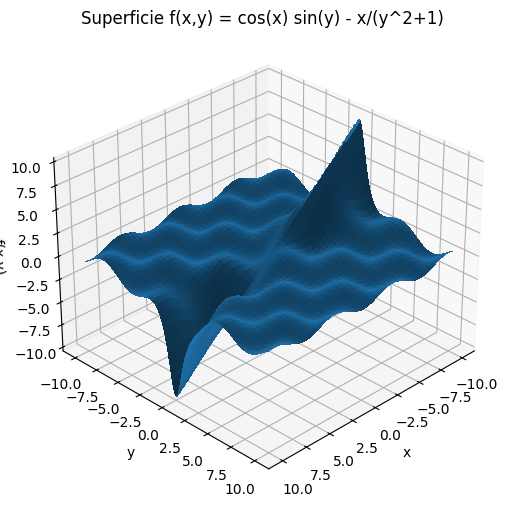

In [13]:
def plot_surface(xmin=-10, xmax=10, ymin=-10, ymax=10, num=200, elev=30, azim=45):
    xs = np.linspace(xmin, xmax, num)
    ys = np.linspace(ymin, ymax, num)
    X, Y = np.meshgrid(xs, ys, indexing="xy")
    Z = np.cos(X) * np.sin(Y) - X / (Y**2 + 1.0)
    from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, linewidth=0, antialiased=False)
    ax.set_title("Superficie f(x,y) = cos(x) sin(y) - x/(y^2+1)")
    ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_zlabel("f(x,y)")
    ax.view_init(elev=elev, azim=azim)
    plt.show()

    
# Ejemplo de graficación (el usuario puede variar los rangos hasta [-100,100])
plot_surface(xmin=-10, xmax=10, ymin=-10, ymax=10, num=150)


## Casos de prueba y comparación

In [14]:

def run_experiments(starts, gd_alpha0_list=[1.0, 0.5, 2.0], newton_alpha0_list=[1.0]):
    rows, paths = [], {}
    for s in starts:
        for a0 in gd_alpha0_list:
            res = gradient_descent(s, alpha0=a0)
            rows.append(dict(alg="GradientDescent", start=s, alpha0=a0, steps=res.steps, f=res.func_val, grad_norm=res.grad_norm, success=res.success, msg=res.message))
            if s == starts[0] and abs(a0-1.0) < 1e-9:
                paths[f"GD (α0={a0})"] = res.path
        for a0 in newton_alpha0_list:
            res = newton_method(s, alpha0=a0)
            rows.append(dict(alg="Newton", start=s, alpha0=a0, steps=res.steps, f=res.func_val, grad_norm=res.grad_norm, success=res.success, msg=res.message))
            if s == starts[0] and abs(a0-1.0) < 1e-9:
                paths[f"Newton (α0={a0})"] = res.path
    return pd.DataFrame(rows), paths

# Puede cambiar starts a cualquier punto dentro de [-100,100])
starts_demo = [(0.0, 0.0), (10.0, 10.0), (-30.0, 20.0), (50.0, -50.0)]
df_results, paths_dict = run_experiments(starts_demo, gd_alpha0_list=[0.25, 1.0, 2.0], newton_alpha0_list=[1.0, 0.5])
df_results

,alg,start,alpha0,steps,f,grad_norm,success,msg
0,GradientDescent,"(0.0, 0.0)",0.25,500,-33.679871,4.314271e+00,False,Max iterations reached
1,GradientDescent,"(0.0, 0.0)",1.00,500,-36.214657,1.220117e+00,False,Max iterations reached
2,GradientDescent,"(0.0, 0.0)",2.00,12,-1.045661,9.772854e-07,True,Converged (grad norm)
3,Newton,"(0.0, 0.0)",1.00,4,-0.987785,1.321119e-09,True,Converged (grad norm)
4,Newton,"(0.0, 0.0)",0.50,21,-0.987785,7.412248e-07,True,Converged (grad norm)
5,GradientDescent,"(10.0, 10.0)",0.25,57,-1.151201,8.792477e-07,True,Converged (grad norm)
6,GradientDescent,"(10.0, 10.0)",1.00,7,-1.151201,4.989498e-08,True,Converged (grad norm)
7,GradientDescent,"(10.0, 10.0)",2.00,500,-1.151201,2.946514e-06,False,Max iterations reached
8,Newton,"(10.0, 10.0)",1.00,5,-0.937488,2.414060e-07,True,Converged (grad norm)
9,Newton,"(10.0, 10.0)",0.50,24,-1.151201,7.204918e-07,True,Converged (grad norm)


## Graficación de Algoritmos

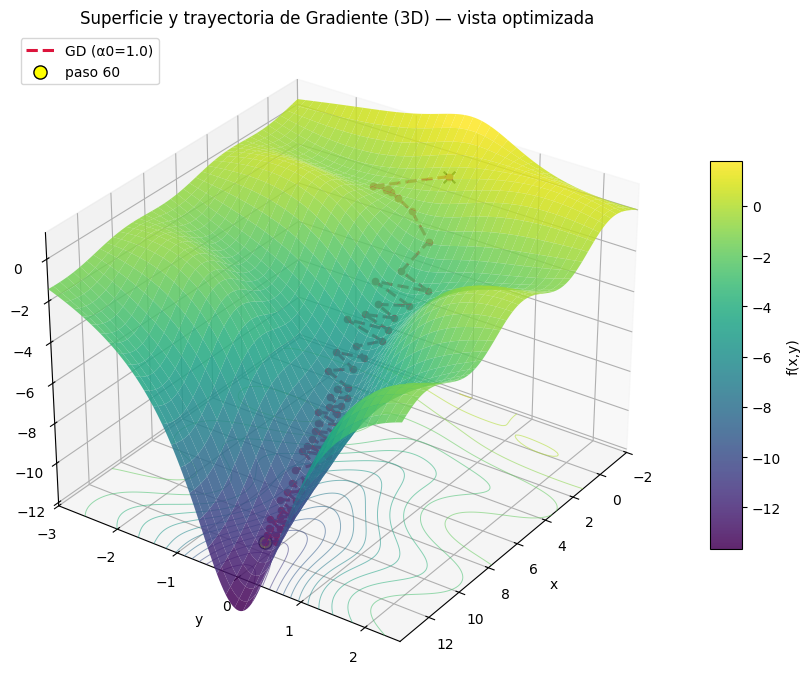

In [ ]:
def plot_gd_path(start=(0.0,0.0), alpha0=1.0, armijo_c=1e-4, armijo_rho=0.5,
                             xmin=None, xmax=None, ymin=None, ymax=None,
                             pad=2.0, num=160, elev=30, azim=35, show_tail=250,
                             kmax=None, highlight_k=None, marker_every=1, lift=0.0):
    """Superficie 3D + trayectoria de GD con control de paso y visibilidad.
    Parámetros:
      start      -- (x0,y0) inicial (para gradient_descent)
      alpha0     -- paso inicial (Armijo lo ajusta)
      kmax       -- plotea hasta ese paso (inclusive); None para toda la ruta/cola
      highlight_k-- resalta ese paso con marcador extra
      marker_every-- usa 1 de cada N puntos para marcadores
      lift       -- eleva la curva en z (añade 'lift' al z) para que no se pierda dentro de la superficie
    """
    res = gradient_descent(start, alpha0=alpha0, armijo_c=armijo_c, armijo_rho=armijo_rho)
    path = np.array(res.path)

    if kmax is not None:
        kmax = max(0, min(int(kmax), len(path)-1))
        path = path[:kmax+1]

    if show_tail is not None and len(path) > show_tail:
        path = path[-show_tail:]

    px_min, py_min = path[:,0].min(), path[:,1].min()
    px_max, py_max = path[:,0].max(), path[:,1].max()
    if xmin is None: xmin = px_min - pad
    if xmax is None: xmax = px_max + pad
    if ymin is None: ymin = py_min - pad
    if ymax is None: ymax = py_max + pad

    xs = np.linspace(xmin, xmax, num)
    ys = np.linspace(ymin, ymax, num)
    X, Y = np.meshgrid(xs, ys, indexing='xy')
    Z = np.cos(X) * np.sin(Y) - X / (Y**2 + 1.0)

    Zp = np.array([f_xy(px, py) for px, py in path])
    allZ = np.concatenate([Z.ravel(), Zp])
    zmin, zmax = np.quantile(allZ, 0.01), np.quantile(allZ, 0.99)

    if lift == 0.0:
        lift = 0.01 * max(1e-9, (zmax - zmin))
    Zp_line = Zp + lift  
    
    fig = plt.figure(figsize=(10,7))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, Z, linewidth=0, antialiased=True, cmap='viridis', edgecolor='none', alpha=0.85)
    ax.contour(X, Y, Z, zdir='z', offset=zmin, levels=15, cmap='viridis', alpha=0.55, linewidths=0.7)

    ax.plot(path[:,0], path[:,1], Zp_line, linestyle='--', linewidth=2.2, color='crimson', label=f'GD (α0={alpha0})', zorder=4)
    if marker_every is None or marker_every < 1:
        marker_every = 1
    pts = path[::marker_every]
    zp_pts = Zp_line[::marker_every]
    ax.scatter(pts[:,0], pts[:,1], zp_pts, s=20, color='crimson', depthshade=False, zorder=5)
    ax.scatter(path[0,0], path[0,1], Zp_line[0], s=70, marker='x', color='k', zorder=6)
    ax.scatter(path[-1,0], path[-1,1], Zp_line[-1], s=70, marker='*', edgecolor='k', color='white', zorder=6)

    if highlight_k is not None:
        hk = max(0, min(int(highlight_k), len(path)-1))
        ax.scatter(path[hk,0], path[hk,1], Zp_line[hk], s=90, marker='o', edgecolor='k', color='yellow', zorder=7, label=f'paso {hk}')

    ax.set_xlim(xmin, xmax); ax.set_ylim(ymin, ymax); ax.set_zlim(zmin, zmax)
    ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('f(x,y)')
    ax.set_title('Superficie y trayectoria de Gradiente (3D) — vista optimizada')
    ax.view_init(elev=elev, azim=azim)
    fig.colorbar(surf, shrink=0.6, aspect=12, pad=0.05, label='f(x,y)')
    ax.legend(loc='upper left')
    plt.tight_layout(); plt.show()

# Ejemplo de uso:
plot_gd_path(start=(0.0,0.0), alpha0=1.0, kmax=60, highlight_k=60)

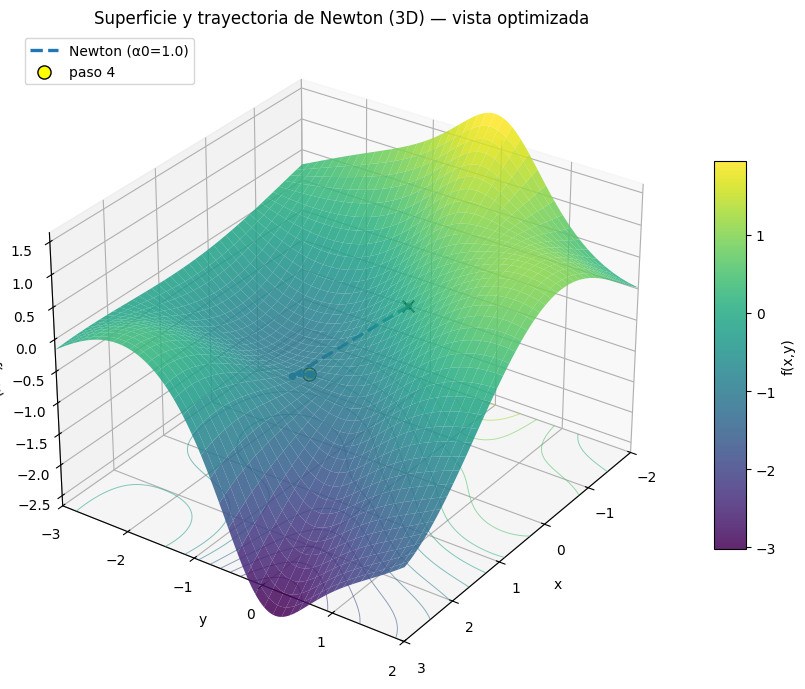

In [23]:
def plot_newton_path(start=(0.0,0.0), alpha0=1.0, armijo_c=1e-4, armijo_rho=0.5,
                               xmin=None, xmax=None, ymin=None, ymax=None,
                               pad=2.0, num=160, elev=30, azim=35, show_tail=250,
                               kmax=None, highlight_k=None, marker_every=1, lift=0.0):
    """Superficie 3D + trayectoria de Newton con control de visibilidad."""
    res = newton_method(start, alpha0=alpha0, armijo_c=armijo_c, armijo_rho=armijo_rho)
    path = np.array(res.path)
    if kmax is not None:
        kmax = max(0, min(int(kmax), len(path)-1))
        path = path[:kmax+1]
    if show_tail is not None and len(path) > show_tail:
        path = path[-show_tail:]
    px_min, py_min = path[:,0].min(), path[:,1].min()
    px_max, py_max = path[:,0].max(), path[:,1].max()
    if xmin is None: xmin = px_min - pad
    if xmax is None: xmax = px_max + pad
    if ymin is None: ymin = py_min - pad
    if ymax is None: ymax = py_max + pad

    xs = np.linspace(xmin, xmax, num)
    ys = np.linspace(ymin, ymax, num)
    X, Y = np.meshgrid(xs, ys, indexing='xy')
    Z = np.cos(X) * np.sin(Y) - X / (Y**2 + 1.0)

    Zp = np.array([f_xy(px, py) for px, py in path])
    allZ = np.concatenate([Z.ravel(), Zp])
    zmin, zmax = np.quantile(allZ, 0.01), np.quantile(allZ, 0.99)
    if lift == 0.0:
        lift = 0.01 * max(1e-9, (zmax - zmin))
    Zp_line = Zp + lift

    fig = plt.figure(figsize=(10,7))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, Z, linewidth=0, antialiased=True, cmap='viridis', edgecolor='none', alpha=0.85)
    ax.contour(X, Y, Z, zdir='z', offset=zmin, levels=15, cmap='viridis', alpha=0.55, linewidths=0.7)

    ax.plot(path[:,0], path[:,1], Zp_line, linestyle='--', linewidth=2.4, color='tab:blue', label=f'Newton (α0={alpha0})', zorder=4)
    if marker_every is None or marker_every < 1:
        marker_every = 1
    pts = path[::marker_every]; zp_pts = Zp_line[::marker_every]
    ax.scatter(pts[:,0], pts[:,1], zp_pts, s=20, color='tab:blue', depthshade=False, zorder=5)
    ax.scatter(path[0,0], path[0,1], Zp_line[0], s=70, marker='x', color='k', zorder=6)
    ax.scatter(path[-1,0], path[-1,1], Zp_line[-1], s=70, marker='*', edgecolor='k', color='white', zorder=6)
    if highlight_k is not None:
        hk = max(0, min(int(highlight_k), len(path)-1))
        ax.scatter(path[hk,0], path[hk,1], Zp_line[hk], s=90, marker='o', edgecolor='k', color='yellow', zorder=7, label=f'paso {hk}')

    ax.set_xlim(xmin, xmax); ax.set_ylim(ymin, ymax); ax.set_zlim(zmin, zmax)
    ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('f(x,y)')
    ax.set_title('Superficie y trayectoria de Newton (3D) — vista optimizada')
    ax.view_init(elev=elev, azim=azim)
    fig.colorbar(surf, shrink=0.6, aspect=12, pad=0.05, label='f(x,y)')
    ax.legend(loc='upper left')
    plt.tight_layout(); plt.show()

# Ejemplo de uso 
plot_newton_path(start=(0.0,0.0), alpha0=1.0, kmax=6, highlight_k=6)